In [1]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import xarray as xr
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

from math import log10, floor, pow, e, sqrt

from functions import *

d:\GithubProjects\canopycontrols-2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
'''Import Data Links'''
import_path = "./data/site-data/"
paper_savepath = "./figures/"

'''Colors'''
pal = sns.color_palette(["#ffffcc", "#c2e699", "#78c679", "#31a354", "#006837"], 5, as_cmap= True)

'''File Functions'''
def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

#Compute Hill-Simpson Diversity Metric
def calcS(co, dom, int, sup):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot
    pDom = dom/tot
    pInt = int/tot
    pSup = sup/tot

    #calc index masking any zeroes
    S = np.sum(pow(pCo, 2) + pow(pDom, 2) + pow(pInt, 2) + pow(pSup, 2))

    return 1/S

#Piecewise
def func(x, x0, y0, k1, k2):
    y = np.piecewise(x, [x < x0, x >= x0],
                     [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
    return y



### Import and Setup

In [5]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset(import_path + '01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset(import_path + '01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

### Import LAI Data
s2LAI = pd.read_csv(import_path + "S2_winterLAI_calibrated.csv")
s6LAI = pd.read_csv(import_path + "S6_winterLAI_calibrated.csv")
lai_df = pd.concat([s2LAI, s6LAI]).reset_index()

### Import forestry Data -- summarized by stake
forestInv = pd.read_csv(import_path + 'VegData_LAI_Snow.csv')

In [8]:
'''Data QAQCing'''
#Add Snow Years
#Snow year
allSnow_df['SYear'] = [2024 if allSnow_df.time[i] > pd.to_datetime('09-01-2023') else 2023 for i in range(0, len(allSnow_df.time))]

#Date of snow year
allSnow_df['SDOY'] = [(allSnow_df.time[i] - pd.to_datetime('09-01-2023')).days if allSnow_df.SYear[i] == 2024 else (allSnow_df.time[i] - pd.to_datetime('09-01-2022')).days for i in range(0, len(allSnow_df.time))]

#Retrofit one veg data outlier
#Stake S234 -- labelled all bog trees at dominant when they probably should have been codominant
forestInv.loc[18,  'Co'] = [20]
forestInv.loc[18,  'Dom'] = [0]

In [11]:
'''Organize all data into one data frame'''
#Remove rows on allSnow containing NaNs (these are grid locations where data was not taken)
allSnow_nan = allSnow_df.dropna(how = 'any')

#Take peak snow depth per site
peakSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'SYear'])['depths'].max().reset_index()
peakSnow = peakSnow.rename(columns = {'depths' : 'maxDepth'})

#Take average snow depth per site
avgSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'SYear'])['depths'].mean().reset_index()
avgSnow = avgSnow.rename(columns = {'depths' : 'meanDepth'})

#Add in other columns aggregated by year, joined on stakes
## LAI
lai_sub = lai_df[['Stake_ID', 'OLS Prediction Ring 5']]
peakData = pd.merge(peakSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

avgData = pd.merge(avgSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

## Veg Survey
veg_sub = forestInv[['Stake_ID', 'DIST_M', 'DBH_CM', 'DIST_M_SD', 'DBH_CM_SD', 'n', 'basalArea_m2', 'Co', 'Dom', 'Int', 'Sup', 'prop_Coniferous']]
peakData = pd.merge(peakData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_cm',
                                    'DIST_M_SD' : 'sdDist_m',
                                    'DBH_CM_SD' : 'sdDBH_cm',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

avgData = pd.merge(avgData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_cm',
                                    'DIST_M_SD' : 'sdDist_m',
                                    'DBH_CM_SD' : 'sdDBH_cm',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

#Save peak data
peakData.to_csv(import_path + 'peak-snow-data.csv', index = False)

### Initial LAI Analysis

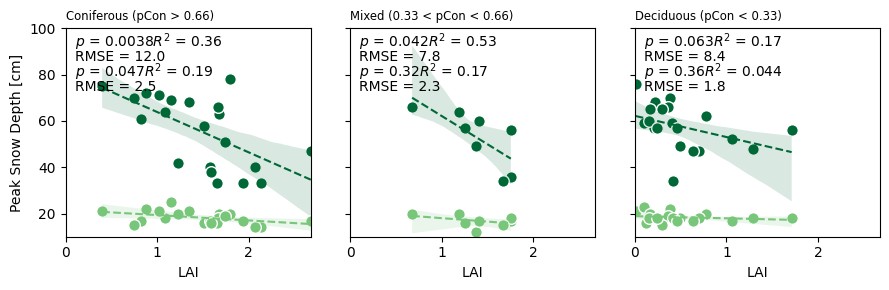

In [15]:
#Prep Data
bins = list(np.linspace(np.nanmin(peakData.pCon), np.nanmax(peakData.pCon), 4))
labels = ['Dense Deciduous', 'Mixed', 'Dense Coniferous']
peakData['Bin'] = pd.cut(peakData['pCon'], include_lowest = True, bins = bins, labels = labels)

#Plotting function
def plotLAICovertype(data, ax, color, xlab, ylab):
    sns.regplot(data = data, x = 'lai5ring', y = 'maxDepth', 
                ax = ax, 
                color = color, 
                label = 'High Snow', 
                scatter_kws = {'s' : 70, 'edgecolor' : "white", 'alpha' : 1}, 
                line_kws = {'linestyle' : '--', 'linewidth' : 1.5})
    mod = smf.ols('maxDepth ~ lai5ring', data = data).fit()
    ax.text(xlab, ylab, r'$ p $ = ' + str(round_sig(mod.pvalues.lai5ring, 2)) + r'$ R^2 $ = ' + str(round_sig(mod.rsquared, 2)))
    ax.text(xlab, ylab - 6, 'RMSE = ' + str(round_sig(sqrt(np.sum((mod.resid)**2)/(len(mod.resid))), 2)))

#Plot - Figure 3
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')


plotLAICovertype(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2023)], ax1, pal[4], 0.1, 92)
plotLAICovertype(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2024)], ax1, pal[2], 0.1, 79)
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('LAI')

plotLAICovertype(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2023)], ax2, pal[4], 0.1, 92)
plotLAICovertype(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2024)], ax2, pal[2], 0.1, 79)
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('LAI')

plotLAICovertype(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2023)], ax3, pal[4], 0.1, 92)
plotLAICovertype(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2024)], ax3, pal[2], 0.1, 79)
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('LAI')

ax1.set_xlim(0, max(peakData.lai5ring))
ax1.set_ylim(10, 100)

plt.savefig(paper_savepath + 'figure3-covertype_lairegression.pdf', bbox_inches = 'tight')

### Random Forest Variable Importance

In [18]:
'''Set PCA Data'''
#Switch this depending on average/maximum snow depth considerations
pca_data = peakData

#remove strings
pca_data_forplot = pca_data.drop(columns = ['stakes', 'zones', 'watershed', 'Bin'])

#remove depths 
pca_data = pca_data_forplot.drop(columns = 'maxDepth')

#Standardize Data
scaler = StandardScaler()
scaler.fit(pca_data)
pca_data_scaled = scaler.transform(pca_data)
#Convert back to dataframe
pca_scaled = pd.DataFrame(data = pca_data_scaled, 
                            columns = pca_data.columns)

#Run PCA
pca = PCA(n_components = 10) #adjustable
pca.fit_transform(pca_data_scaled)

#Extract variance values
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

C:\Users\marie\AppData\Local\Temp\ipykernel_28476\658983910.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)


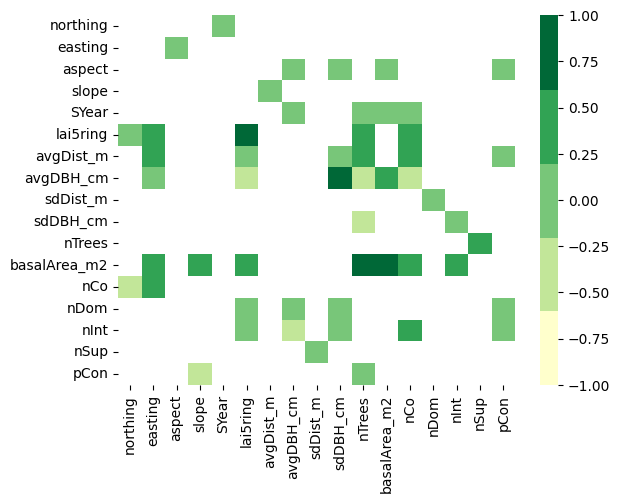

In [19]:
#Variable intercorrelation
pvals = calculate_pvalues(pca_data) 
sigvals = np.where(pvals < 0.05, pvals, np.nan)

sns.heatmap(pca_data.corr(),
                xticklabels=pca_data.columns,
                yticklabels=pca_data.columns, 
            cmap = pal, 
            mask = sigvals, 
            center = 0, 
            vmin = -1, vmax = 1)

plt.savefig(paper_savepath + 'supplementalfigure1-correlation_heatmap.pdf', bbox_inches = 'tight')

#### Random Forest Model for Peak Snow Depth

In [ ]:
#Remove highly correlated variables
pca_data_reduced = pca_data.drop(columns = ['northing', 'easting', 'SYear', 'nTrees', 'basalArea_m2', 'nInt', 'nSup', 'nDom'])

In [ ]:
#Split data
X_train_reduced_2023, X_test_reduced_2023, y_train_reduced_2023, y_test_reduced_2023 = train_test_split(pca_data_reduced[pca_data.SYear == 2023],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2023].maxDepth,
                                                                        test_size = 0.2, random_state = 48492)
X_train_reduced_2024, X_test_reduced_2024, y_train_reduced_2024, y_test_reduced_2024 = train_test_split(pca_data_reduced[pca_data.SYear == 2024],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2024].maxDepth,
                                                                        test_size = 0.2, random_state = 48492)

#Initial Fit random forest regression with 100 trees
rf2023_red = RandomForestRegressor(n_estimators = 100, max_depth = 5)
rf2023_red.fit(X_train_reduced_2023, y_train_reduced_2023)
rf2024_red = RandomForestRegressor(n_estimators = 100, max_depth = 5)
rf2024_red.fit(X_train_reduced_2024, y_train_reduced_2024)

#Model assessment
preds2023_red = rf2023_red.predict(X_test_reduced_2023)
preds2024_red = rf2024_red.predict(X_test_reduced_2024)

y2023 = y_test_reduced_2023
print('2023 Snow Year ')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y2023, preds2023_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y2023, preds2023_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y2023, preds2023_red)))
mape = np.mean(np.abs((y2023 - preds2023_red) / np.abs(y2023)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf2023_red.score(X_train_reduced_2023, y_train_reduced_2023))
print('Testing Score:', rf2023_red.score(X_test_reduced_2023, y_test_reduced_2023))
print('Accuracy:', round(100*(1 - mape), 2))

y2024 = y_test_reduced_2024
print('\n2024 Snow Year ')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y2024, preds2024_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y2024, preds2024_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y2024, preds2024_red)))
mape = np.mean(np.abs((y2024 - preds2024_red) / np.abs(y2024)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf2024_red.score(X_train_reduced_2024, y_train_reduced_2024))
print('Testing Score:', rf2024_red.score(X_test_reduced_2024, y_test_reduced_2024))
print('Accuracy:', round(100*(1 - mape), 2))

2023 Snow Year 
Mean Absolute Error (MAE): 7.6064862808759885
Mean Squared Error (MSE): 89.8857284653432
Root Mean Squared Error (RMSE): 9.480808428891663
Mean Absolute Percentage Error (MAPE): 16.34
Training Score: 0.9208684234442545
Testing Score: 0.4798580610766553
Accuracy: 83.66

2024 Snow Year 
Mean Absolute Error (MAE): 2.034393667443668
Mean Squared Error (MSE): 5.0474916502326925
Root Mean Squared Error (RMSE): 2.246662335606464
Mean Absolute Percentage Error (MAPE): 11.74
Training Score: 0.8239712999753206
Testing Score: -0.36788391605222026
Accuracy: 88.26


#### ML Model Tuning

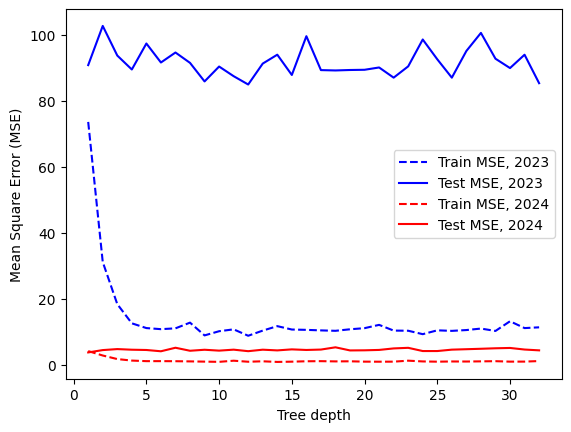

In [25]:
#Test different model hyperparameters
max_depths = np.linspace(1, 32, 32, endpoint=True, dtype = 'int')

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for max_depth in max_depths:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 100, max_depth = max_depth, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 100, max_depth = max_depth, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = max_depths, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = max_depths, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = max_depths, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = max_depths, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Tree depth')
plt.show()

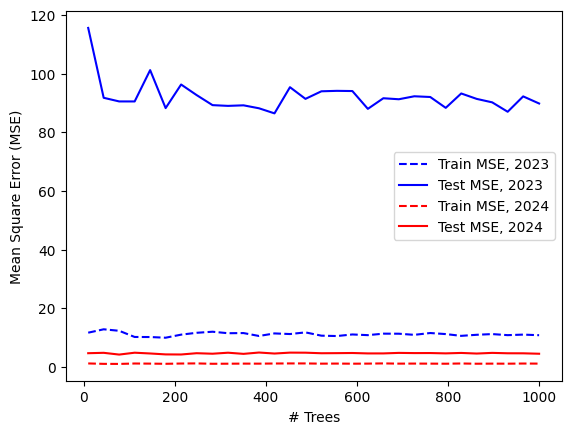

In [41]:
#Test different model hyperparameters
n_trees = np.linspace(10, 1000, 30, endpoint=True, dtype = 'int')

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for tree in n_trees:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = tree, max_depth = 5, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = tree, max_depth = 5, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = n_trees, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = n_trees, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = n_trees, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = n_trees, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('# Trees')
plt.show()

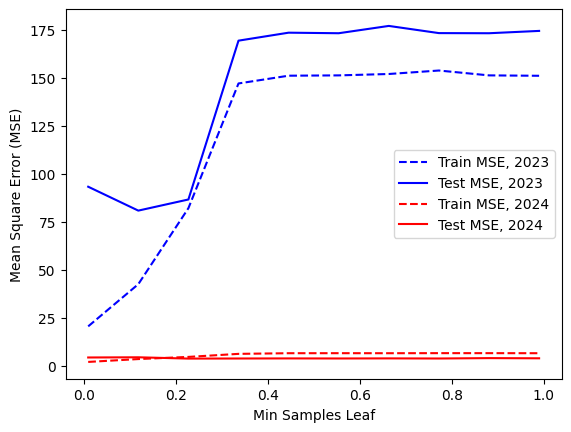

In [42]:
#Test different model hyperparameters
min_samples_leafs = np.linspace(0.01, 0.99, 10, endpoint=True)

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for leaf in min_samples_leafs:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = leaf, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = leaf, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = min_samples_leafs, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = min_samples_leafs, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = min_samples_leafs, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = min_samples_leafs, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Min Samples Leaf')
plt.show()

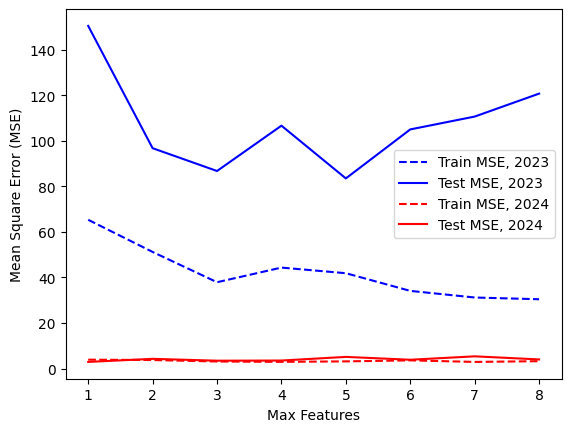

In [43]:
#Test different model hyperparameters
max_features = list(range(1,X_train_reduced_2023.shape[1]))

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for feature in max_features:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = 0.1, max_features = feature, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = 0.1, max_features = feature, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = max_features, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = max_features, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = max_features, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = max_features, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Max Features')
plt.show()

#### All data - Tuned Model

In [28]:
# Leave in Snow year to use to separate SHAP plots
pca_data_reduced_all = pca_data.drop(columns = ['northing', 'easting', 'nTrees', 'basalArea_m2', 'nInt', 'nSup', 'nDom'])

#Split data
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(pca_data_reduced_all,
                                                                        pca_data_forplot.maxDepth,
                                                                        test_size = 0.2, random_state = 48492)

#Test different model hyperparameters
params = np.linspace(1, 32, 32, endpoint=True, dtype = 'int') #tree depths
#params = np.linspace(10, 1000, 30, endpoint=True, dtype = 'int') #n trees
#params = np.linspace(0.01, 0.99, 10, endpoint=True) #min leafs
#params  = list(range(1,X_train_reduced.shape[1])) # max features

train_results = []
test_results = []

for param in params:
   #Fit models
   rf = RandomForestRegressor(n_estimators = 100, max_depth = 3, min_samples_leaf = 0.1, max_features = 9, n_jobs = -1)
   rf.fit(X_train_reduced, y_train_reduced)

   #Predict data
   train_pred = rf.predict(X_train_reduced)
   y_pred = rf.predict(X_test_reduced)

   #Calculate MSE
   train_results.append(metrics.mean_squared_error(y_train_reduced, train_pred))
   test_results.append(metrics.mean_squared_error(y_test_reduced, y_pred))


#Fit random forest regression with tuned hyperparameters
rf_red = RandomForestRegressor(n_estimators = 100, max_depth = 3, min_samples_leaf = 0.1, max_features = 9)
rf_red.fit(X_train_reduced, y_train_reduced)


preds_red = rf_red.predict(X_test_reduced)

y = y_test_reduced
print('All Snow Years')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y, preds_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y, preds_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y, preds_red)))
mape = np.mean(np.abs((y - preds_red) / np.abs(y)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf_red.score(X_train_reduced, y_train_reduced))
print('Testing Score:', rf_red.score(X_test_reduced, y_test_reduced))
print('Accuracy:', round(100*(1 - mape), 2))

All Snow Years
Mean Absolute Error (MAE): 4.737211405875017
Mean Squared Error (MSE): 43.57616558807898
Root Mean Squared Error (RMSE): 6.601224552162953
Mean Absolute Percentage Error (MAPE): 11.91
Training Score: 0.9158554428659974
Testing Score: 0.9137037278436332
Accuracy: 88.09


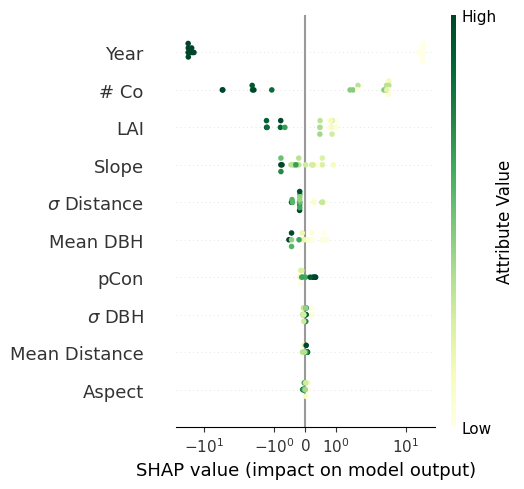

In [29]:
#Figure 4 - SHAP values
explainer_red = shap.TreeExplainer(rf_red)
shap_values_red = explainer_red.shap_values(X_test_reduced)

fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values_red, X_test_reduced,
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
ax.set_yticklabels(['Aspect', 'Mean Distance', r'$\sigma$ DBH', 'pCon', 'Mean DBH', r'$\sigma$ Distance', 'Slope','LAI', '# Co', 'Year'])
plt.savefig(paper_savepath + 'figure4-full_shapanalysis.pdf', bbox_inches = 'tight')
plt.show()

In [30]:
#Pull out row shap data for each snow year
s2023_ids = np.where(X_test_reduced.SYear == 2023)
sv2023 = shap_values_red[s2023_ids]

s2024_ids = np.where(X_test_reduced.SYear == 2024)
sv2024 = shap_values_red[s2024_ids]

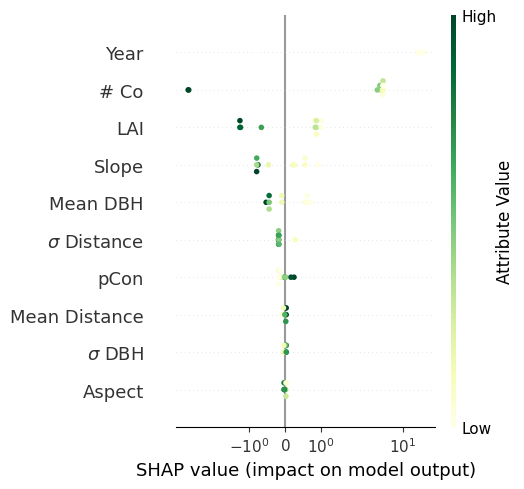

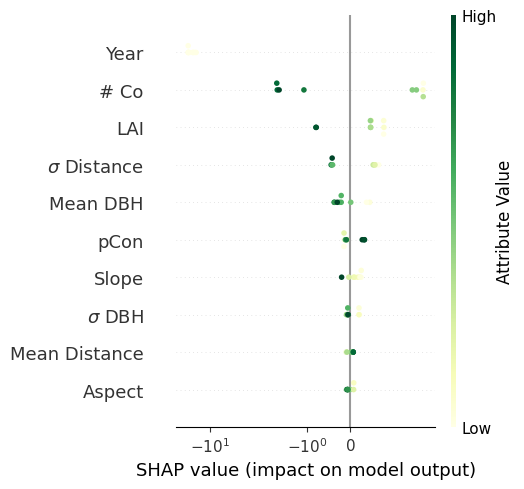

In [31]:
fig, ax = plt.subplots(1, 1)
shap.summary_plot(sv2023, X_test_reduced[X_test_reduced.SYear == 2023],
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
ax.set_yticklabels(['Aspect', r'$\sigma$ DBH', 'Mean Distance', 'pCon', r'$\sigma$ Distance', 'Mean DBH', 'Slope','LAI', '# Co', 'Year'])
plt.savefig(paper_savepath + 'figure4-2023_shapanalysis.pdf', bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(1, 1)
shap.summary_plot(sv2024, X_test_reduced[X_test_reduced.SYear == 2024],
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
ax.set_yticklabels(['Aspect', 'Mean Distance', r'$\sigma$ DBH', 'Slope', 'pCon', 'Mean DBH', r'$\sigma$ Distance', 'LAI', '# Co', 'Year'])
plt.savefig(paper_savepath + 'figure4-2024_shapanalysis.pdf', bbox_inches = 'tight')
plt.show()

### Diversity Analysis

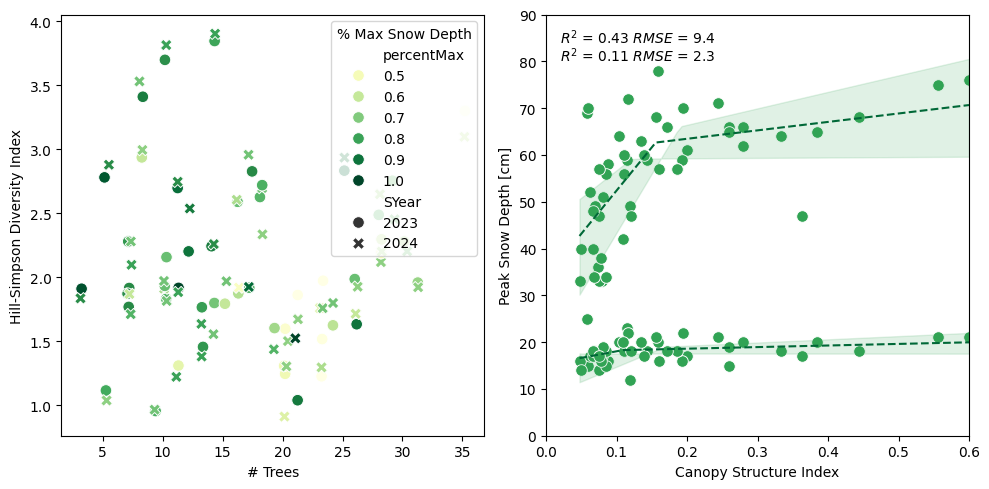

In [33]:
#Calculate Hill Simpson Index
peakData['S'] = [calcS(peakData.nCo[i], peakData.nDom[i], peakData.nInt[i], peakData.nSup[i]) for i in peakData.index]

#Plot variability vs. magnitude
fig, [ax, ax1] = plt.subplots(1, 2, figsize = (10, 5), 
                              layout = 'tight')

#Scatterplot with snow above minimum recorded depth
max2023 = max(peakData[peakData.SYear == 2023].maxDepth)
max2024 = max(peakData[peakData.SYear == 2024].maxDepth)
peakData['percentMax'] = [((peakData.maxDepth[i]/max2023) if (peakData.SYear[i] == 2023) else (peakData.maxDepth[i]/max2024)) for i in peakData.index]
sns.scatterplot(x = jitter(peakData['nTrees'], 0.25), y = jitter(peakData['S'], 0.05), hue = peakData['percentMax'], 
            style = peakData.SYear,
            palette = 'YlGn', 
            s = 70, 
            ax = ax)

ax.legend(title = '% Max Snow Depth')
ax.set_xlabel('# Trees')
ax.set_ylabel('Hill-Simpson Diversity Index')

peakData['divIndex'] = peakData.S/(peakData.nTrees)
forFit = peakData.dropna(how='any')
x_fit2023 = forFit[forFit.SYear == 2023].divIndex.to_numpy()
y_fit2023 = forFit[forFit.SYear == 2023].maxDepth.to_numpy()
x_fit2024 = forFit[forFit.SYear == 2024].divIndex.to_numpy()
y_fit2024 = forFit[forFit.SYear == 2024].maxDepth.to_numpy()

##Fit 2023
p2023 = [0.12, 60, 600, 20] #initial optimization guesses
popt2023, pcov2023 = curve_fit(func, x_fit2023, y_fit2023, p0 = p2023)
#Rsquared calculation
residuals2023 = y_fit2023 - func(x_fit2023, *popt2023)
ss_res2023 = np.sum(residuals2023**2)
ss_tot2023 = np.sum((y_fit2023 - np.mean(y_fit2023))**2)
r_squared2023 = 1 - (ss_res2023 / ss_tot2023)
#RMSE calculation
RMSE2023 = sqrt(np.sum((residuals2023)**2)/(len(residuals2023)))

##Fit 2024
p2024 = [0.1, 18, 90, 10] #initial optimization guesses
popt2024, pcov2024 = curve_fit(func, x_fit2024, y_fit2024, p0 = p2024)
#Rsquared calculation
residuals2024 = y_fit2024 - func(x_fit2024, *popt2024)
ss_res2024 = np.sum(residuals2024**2)
ss_tot2024 = np.sum((y_fit2024 - np.mean(y_fit2024))**2)
r_squared2024 = 1 - (ss_res2024 / ss_tot2024)
#RMSE calculation
RMSE2024 = sqrt(np.sum((residuals2024)**2)/(len(residuals2024)))

#Scatterplot
sns.scatterplot(data = peakData, x = 'divIndex', y = 'maxDepth', color = pal[3], s = 70, ax = ax1)

#plot 2023
x2023 = np.sort(x_fit2023)
ax1.plot(x2023, func(x2023, *popt2023), linestyle = '--', color = pal[4])

#plot 2024
x2024 = np.sort(x_fit2024)
ax1.plot(x2024, func(x2024, *popt2024), linestyle = '--', color = pal[4])

#2023 Add 90% confidence interval
sigma_ab2023 = np.sqrt(np.diagonal(pcov2023))
bound_upper2023 = func(x2023, *(popt2023 + sigma_ab2023))
bound_lower2023 = func(x2023, *(popt2023 - sigma_ab2023))
plt.fill_between(x2023, bound_lower2023, bound_upper2023,
                 alpha = 0.15, 
                 color = pal[3])

#2024 Add 90% confidence interval
sigma_ab2024 = np.sqrt(np.diagonal(pcov2024))
bound_upper2024 = func(x2024, *(popt2024 + sigma_ab2024))
bound_lower2024 = func(x2024, *(popt2024 - sigma_ab2024))
plt.fill_between(x2024, bound_lower2024, bound_upper2024,
                 alpha = 0.15, 
                 color = pal[3])

ax1.text(0.02, 84, '$ R^2 $ = ' + str(round_sig(r_squared2023, 2)) + ' $ RMSE $ = ' + str(round_sig(RMSE2023, 2)))
ax1.text(0.02, 80, '$ R^2 $ = ' + str(round_sig(r_squared2024, 2)) + ' $ RMSE $ = ' + str(round_sig(RMSE2024, 2)))
ax1.set_xlabel('Canopy Structure Index')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlim(0, max(peakData.divIndex))
ax1.set_ylim(0, 90)

plt.savefig(paper_savepath + 'supplementalfigure2-Diversity_analysis.pdf')


### Repeat Cover Diagram

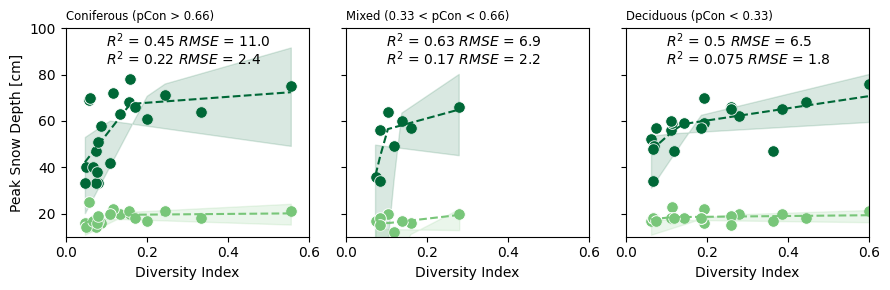

In [34]:
def plotPieceWise(data, ax, color, xlab, ylab, p):
    #Preprocessing
    x_fit = data[data.divIndex > 0].divIndex.to_numpy()
    y_fit = data[data.divIndex > 0].maxDepth.to_numpy()

    #Fit function
    popt, pcov = curve_fit(func, x_fit, y_fit, p0 = p) #comment out the initial parameter guesses to get linear regression

    #Rsquared calculation
    residuals = y_fit - func(x_fit, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
    r_squared = 1 - (ss_res / ss_tot)

    #RMSE calculation
    RMSE = sqrt(np.sum((residuals)**2)/(len(residuals)))

    #Plot Data
    #Scatterplot
    sns.scatterplot(data = data, x = 'divIndex', y = 'maxDepth', color = color, s = 70, ax = ax)

    #Plot line
    x_plot = np.sort(x_fit)
    ax.plot(x_plot, func(x_plot, *popt), linestyle = '--', color = color)

    #Add 90% confidence interval
    sigma_ab = np.sqrt(np.diagonal(pcov))
    bound_upper = func(x_plot, *(popt + sigma_ab))
    bound_lower = func(x_plot, *(popt - sigma_ab))
    ax.fill_between(x_plot, bound_lower, bound_upper,
                    alpha = 0.15, 
                    color = color)
    
    #add text
    ax.text(xlab, ylab, '$ R^2 $ = ' + str(round_sig(r_squared, 2)) + ' $ RMSE $ = ' + str(round_sig(RMSE, 2)))

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')




#Dense Coniferous
plotPieceWise(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2023)], ax1, pal[4], 0.1, 92, [0.12, 60, 600, 20])
plotPieceWise(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2024)], ax1, pal[2], 0.1, 84, [0.1, 18, 90, 10])
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('Diversity Index')


#Mixed 
plotPieceWise(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2023)], ax2, pal[4], 0.1, 92, [0.12, 60, 600, 20])
plotPieceWise(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2024)], ax2, pal[2], 0.1, 84, [0.1, 18, 90, 10])
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('Diversity Index')

#Dense Deciduous
plotPieceWise(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2023)], ax3, pal[4], 0.1, 92, [0.12, 60, 600, 20])
plotPieceWise(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2024)], ax3, pal[2], 0.1, 84, [0.1, 18, 90, 10])
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('Diversity Index')

ax1.set_xlim(0, max(peakData.divIndex))
ax1.set_ylim(10, 100)

plt.savefig(paper_savepath + 'figure7-covertype_diversityregression_piecewise.pdf', bbox_inches = 'tight')

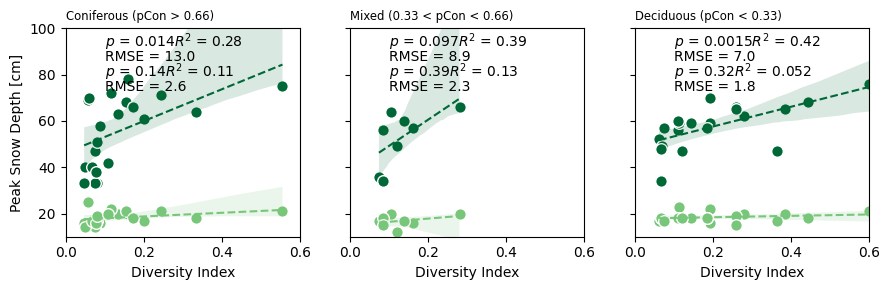

In [35]:
#Plotting function
def plotDiversityCovertype(data, ax, color, xlab, ylab):
    x_fit = data[data.divIndex > 0].divIndex.to_numpy()
    y_fit = data[data.divIndex > 0].maxDepth.to_numpy()
    sns.regplot(x = x_fit, y = y_fit, 
                ax = ax, 
                color = color, 
                scatter_kws = {'s' : 70, 'edgecolor' : "white", 'alpha' : 1}, 
                line_kws = {'linestyle' : '--', 'linewidth' : 1.5})
    mod = smf.ols('maxDepth ~ divIndex', data = data).fit()
    ax.text(xlab, ylab, r'$ p $ = ' + str(round_sig(mod.pvalues.divIndex, 2)) + r'$ R^2 $ = ' + str(round_sig(mod.rsquared, 2)))
    ax.text(xlab, ylab - 6, 'RMSE = ' + str(round_sig(sqrt(np.sum((mod.resid)**2)/(len(mod.resid))), 2)))

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')


plotDiversityCovertype(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2023)], ax1, pal[4], 0.1, 92)
plotDiversityCovertype(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2024)], ax1, pal[2], 0.1, 79)
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('Diversity Index')

plotDiversityCovertype(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2023)], ax2, pal[4], 0.1, 92)
plotDiversityCovertype(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2024)], ax2, pal[2], 0.1, 79)
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('Diversity Index')

plotDiversityCovertype(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2023)], ax3, pal[4], 0.1, 92)
plotDiversityCovertype(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2024)], ax3, pal[2], 0.1, 79)
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('Diversity Index')

ax1.set_xlim(0, max(peakData.divIndex))
ax1.set_ylim(10, 100)

plt.savefig(paper_savepath + 'figure7-covertype_diversityregression_linear.pdf', bbox_inches = 'tight')